In [1]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
import os
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy

In [2]:
#use collagen to define dermis
# 1. extract collagen(class=10) from DLmask
# 2. remove small object and fill holes in collagen to make it a single connected body
# 3. find epidermal-dermis junction using maximum of the binary in y-axis
# 4. remove any pixels that are not epidermis above the epidermal-dermis junction
# 5. iterate each class to replace any potentially wrong pixel to correct class
    #hair foliical: adj pixel look at window

In [3]:
#read deeplab crop
dlcropsrc = r'\\fatherserverdw\kyuex\analysis output\datadst\20220929\dlcrop'

In [4]:
#1. remove small object and fill holes in collagen to make it a single connected body
#10x
dl = Image.open(os.path.join(dlcropsrc, "2022-06-07 14.34.59sec1.png"))

In [5]:

dl_arr = np.array(dl)
dl_arr[dl_arr == 12] = 0
col = (dl_arr == 10) #collagen

In [6]:
#2.remove small object and fill holes in collagen to make it a single connected body

minTA = 60000
minTAhole = 10000 #is this too much?

#resize to expedite
(width, height) = (dl.width // 10, dl.height // 10)
collagen = Image.fromarray(col).resize((width, height), resample=0)

collagen= closing(collagen, square(3))  # 13sec
collagen= remove_small_objects(collagen, min_size=minTA, connectivity=2)  # 6sec
collagen = remove_small_holes(collagen , area_threshold=minTAhole).astype(np.uint8)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(collagen .astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
collagen = cv2.dilate(opening, kernel, iterations=3)

#resize back
collagen = Image.fromarray(collagen).resize((dl.width, dl.height),resample=0)
collagen_arr = np.array(collagen)

In [7]:
np.sum(col)

48822244

In [8]:
np.sum(collagen_arr)

73442890

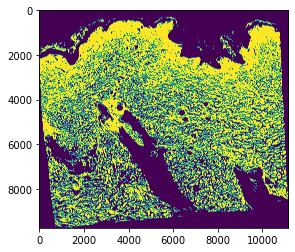

In [9]:
plt.imshow(col)

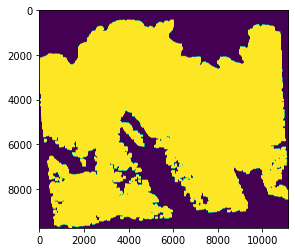

In [10]:
plt.imshow(collagen_arr)

In [11]:
#3. find epidermal-dermis junction
[xt,yt] = np.where(collagen_arr)


In [12]:
#we actually want to find the minimum x-coordinate (because this image is weirdly oriented)
unique_y = np.unique(yt)


In [13]:

min_x = [np.amin(np.where(collagen_arr[:,y])) for y in unique_y]

In [14]:
thresh = 800 #i'm not sure that this will work with every image. TODO: change

In [15]:
hist, bins = np.histogram(min_x)

In [16]:
#get the value range to remove (note: this doesnt contain last element in bins
remove_bins = [b for h,b in zip(hist,bins) if h < thresh ]

In [17]:
#new junction, remove parts with low frequency in histogram,use remove_bins[0] because it represents where the junction begins to drop
#TODO: need to change this to be more robust, what if the junction drops in the middle,
new_junction_x  = [x for x in min_x if x < np.round(remove_bins[0].astype("uint32"))]
new_junction_y = list(range(len(new_junction_x)))

In [18]:
#2: correct anything that is miss classified in epi

In [19]:

epi = deepcopy(dl_arr)
#epi is anything above epidermis-dermis junction
for x,y in zip( new_junction_x,new_junction_y):
    epi[x:, y] = 0

In [20]:
epi[collagen == 1] = 0
epi[:,np.max(new_junction_y):] = 0

In [21]:
#iterate through epi and replace value with 1 or 2, ignore 0 and 12
window_size = 3

for x in range(np.max(new_junction_x)):
    for y in range(np.max(new_junction_y)):
        if not (epi[x,y] == 0 or epi[x,y] == 1 or epi[x,y] == 2 or epi[x,y] == 12):

            #replace pixel value with 1 or 2
            window_shape = [(x -  window_size) if (x -  window_size) >= 0 else 0,
                      (x + window_size) , y +  window_size,(y -  window_size) if (y - window_size) >=0 else 0] #L,R,T,B

            window = epi[window_shape[0]:window_shape[1], window_shape[3]:window_shape[2]]
            #check pixel values in window
            count1 = np.sum([window == 1])
            count2 = np.sum([window == 2])


            if(count1 >= count2):
                epi[x,y] = 1
            elif (count1 < count2):
                epi[x,y] = 2
            else:
                 epi[x,y] = 0




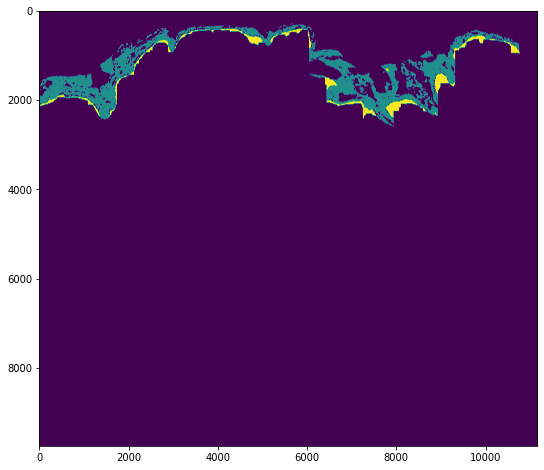

In [22]:
figure_size = plt.gcf().get_size_inches()
factor = 2
plt.gcf().set_size_inches(factor * figure_size)
plt.imshow(epi)

In [23]:
new_dl_arr = deepcopy(dl_arr)

In [24]:
#change new_dl_arr based on new epi
[xt,yt] = np.where(epi == 1)
new_dl_arr[xt,yt] = 1

[xt,yt] = np.where(epi == 2)
new_dl_arr[xt,yt] = 2


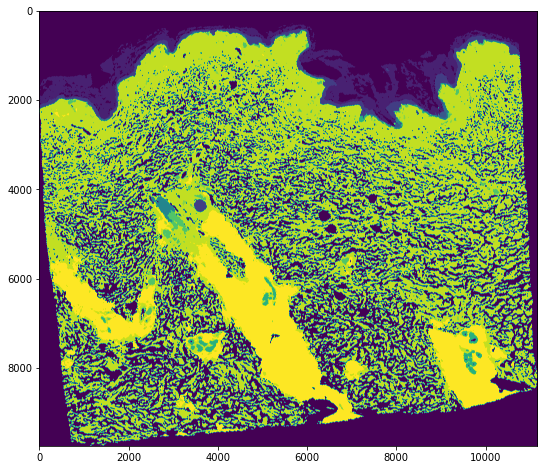

In [25]:
figure_size = plt.gcf().get_size_inches()
factor = 2
plt.gcf().set_size_inches(factor * figure_size)
plt.imshow(new_dl_arr)

In [319]:

#get new contour

import cv2

#TODO: friday: start from here, get contour!!!!
collagen_tmp = deepcopy(collagen_arr)

for x,y in zip( new_junction_x, new_junction_y):
    collagen_tmp[np.max(new_junction_x) + 100:, y] = 0

collagen_tmp[:, np.max(new_junction_y):] = 0

max_cx = max(new_junction_x)
max_cy = max(new_junction_y)

contours, hierarchy = cv2.findContours(collagen_tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [502]:


img = np.zeros((9746, 11162))
cv2.drawContours(img, contours, -1, (255,0,0), 1) #100
img[max_cx + 1:, :] = 0
img= img.astype(bool)
min_x_zero = min((np.where(img[:,0]))[0])

In [489]:

#img[min_x_zero + 1:, 0:20] = 0

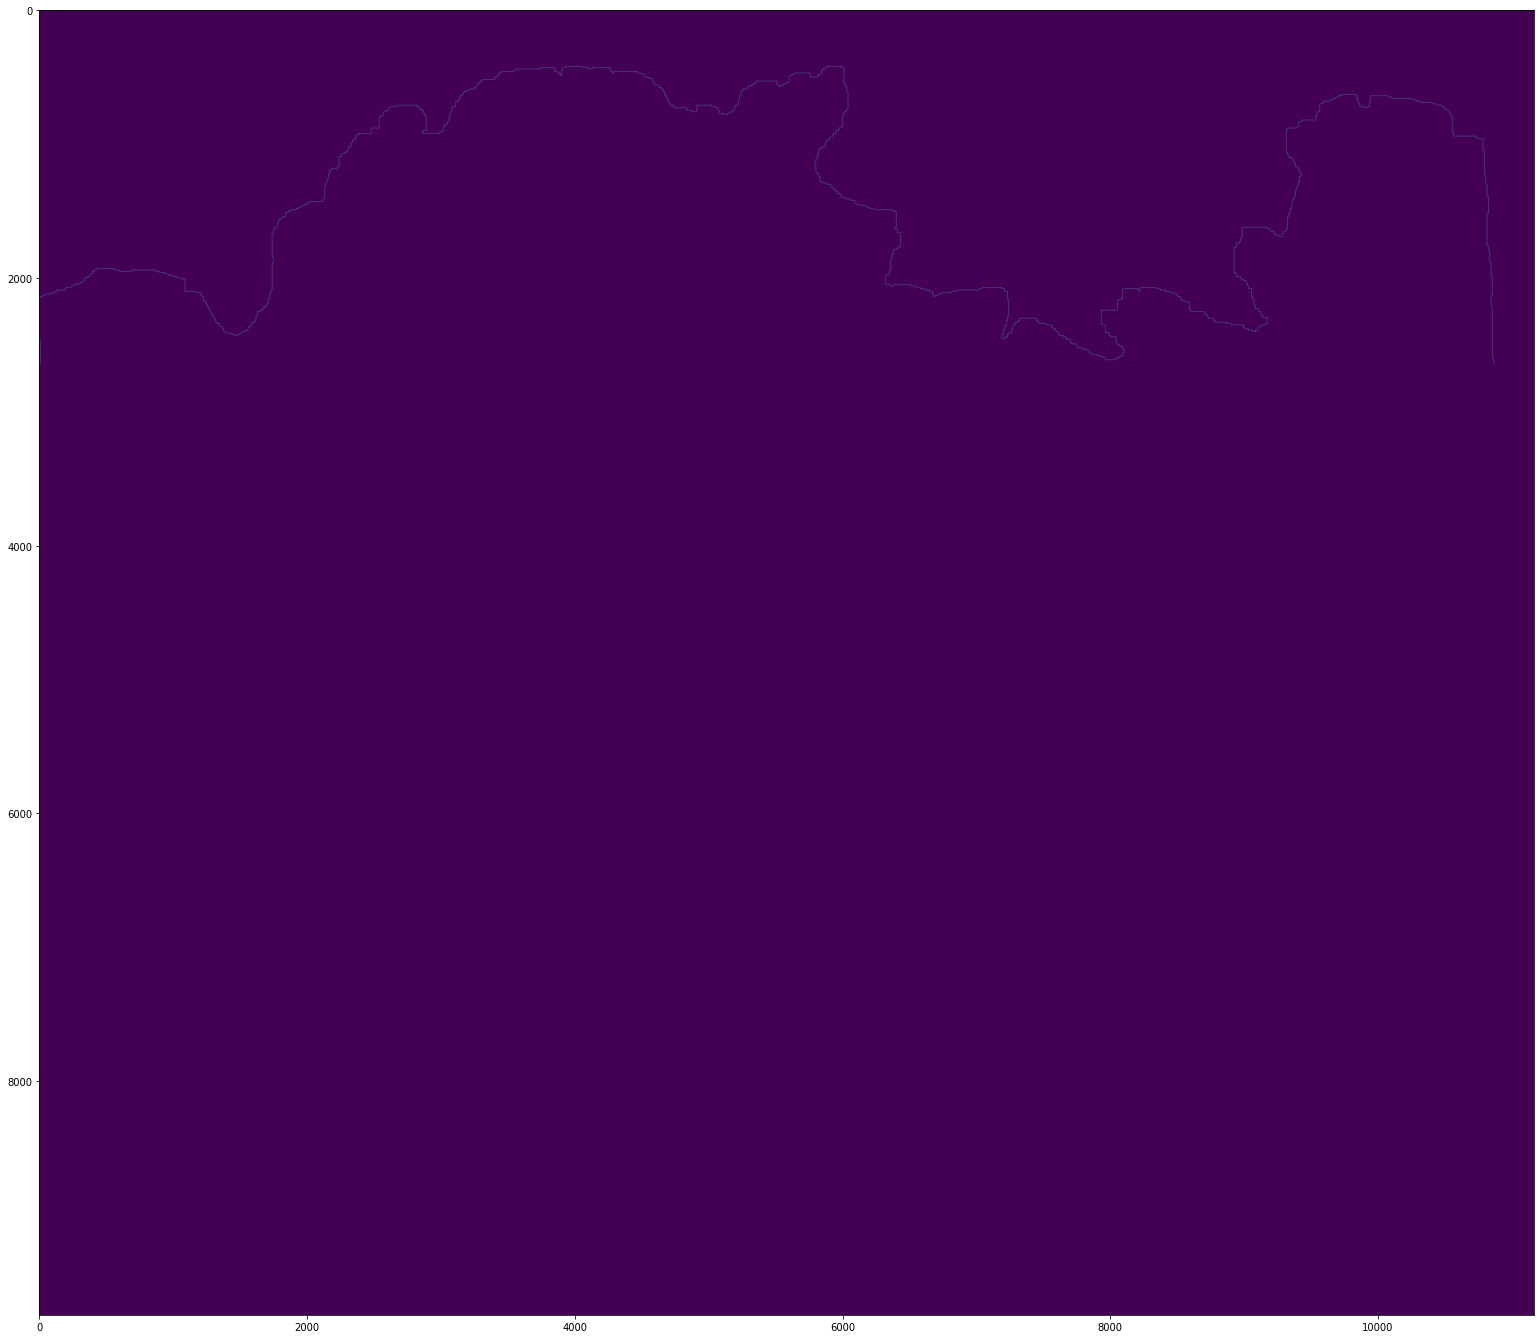

In [503]:

figure_size = plt.gcf().get_size_inches()
factor = 6
plt.gcf().set_size_inches(factor * figure_size)
plt.imshow(img)

In [504]:
[cx,cy] = np.where(img)
#cx = [y for x,y in contours if y < max_cx ]
#cy = [x for x,y in contours if y < max_cx ]

In [505]:
cx

array([ 420,  420,  420, ..., 2642, 2642, 2642], dtype=int64)

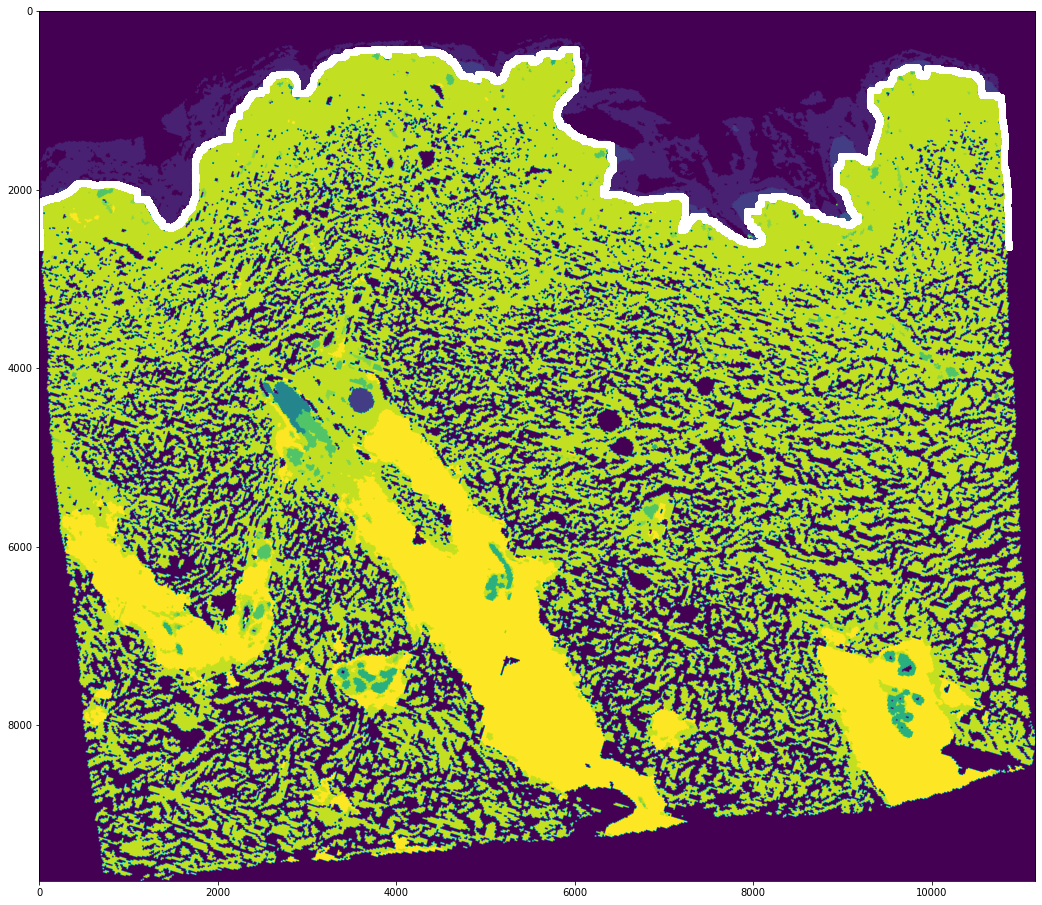

In [506]:
figure_size = plt.gcf().get_size_inches()
factor = 4
plt.gcf().set_size_inches(factor * figure_size)
plt.scatter(cy,cx, color="white", linewidth=1)
plt.imshow(new_dl_arr)

In [507]:
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
import scipy

In [508]:
empty_derm = np.zeros(dl_arr.shape).astype("uint8")

In [509]:
derm= deepcopy(new_dl_arr)

In [510]:
for x,y in zip(cx,cy):
    derm[0:x, y] = 0



In [511]:
#replace any 1, 2 in dermis
derm1 = (derm == 1)  #replace by 3
derm2 = (derm == 2) #replace by 4

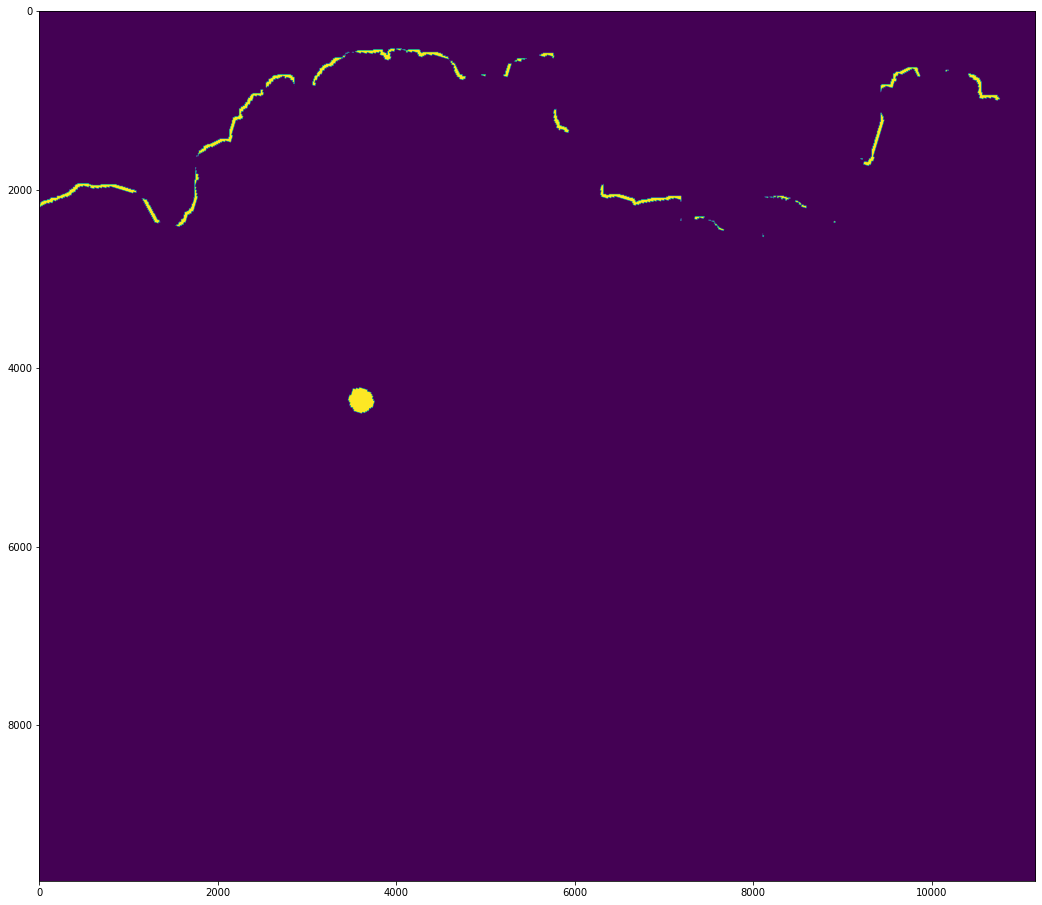

In [512]:
figure_size = plt.gcf().get_size_inches()
factor = 4
plt.gcf().set_size_inches(factor * figure_size)
#plt.scatter(cy,cx, color="white", linewidth=1)

plt.imshow(derm2)

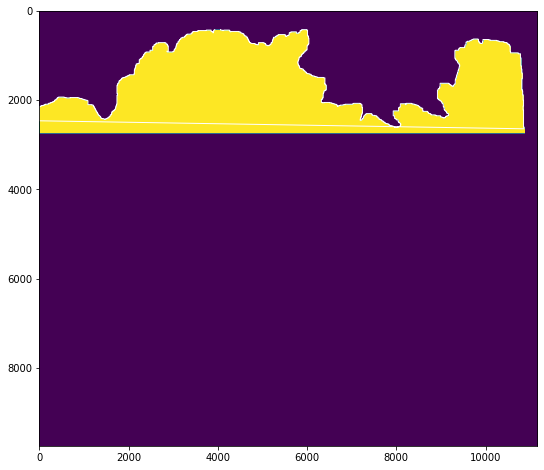

In [193]:
figure_size = plt.gcf().get_size_inches()
factor = 2
plt.gcf().set_size_inches(factor * figure_size)
plt.plot(cy,cx, color="white", linewidth=1)

#plt.imshow((dl_arr == 1) | (dl_arr == 2))
plt.imshow(collagen_tmp)
plt.show()

In [ ]:
#3 should have nothing else in it,should be touching four
derm3 = (derm == 3)
derm3 = ndimage.binary_fill_holes(derm3).astype(int)

#dilate derm3 to create a ring around derm3, check if the rings contain 4
#if not, remove everything in that ring
dilate3 = ndimage.binary_dilation(derm3).astype(derm3.dtype)


ring3 = dilate3 - derm3
nonbin_ring = ring3 * derm #ring with tissue section ids
label_ring = label(ring3)

dilate3[dilate3 == 1] = 3
ring3[ring3 == 1] = 3

In [ ]:


#this step eliminates any 3 not touching 4
for i in np.unique(label_ring)[1:]: #0 is background
    tmp = (label_ring == i) & (derm == 4) #check if 3 is touching 4

    if np.sum(tmp) == 0:
        #TODO: change pixel value to the majority of the ring
        select_ring = (label_ring == i) * nonbin_ring
        count = np.bincount(np.ndarray.flatten(select_ring))

        idx = np.argmax(count[1:] ) + 1
        tmp2 = (label_ring == i)
        tmp3 = ndimage.binary_fill_holes(tmp2).astype(int)
        #final_region = tmp3 - tmp2
        dilate3[tmp3 == 1] = idx #when you subtract you get the inside
        print(idx)

#get new derm3

derm3 = dilate3 - ring3



#update new dermis mask
empty_derm = empty_derm + derm3


In [ ]:
#4 should be big enough, should only have 3 and 6 inside
#how big: above 2000px (above 20 cells)
thres_derm4_area = 2000

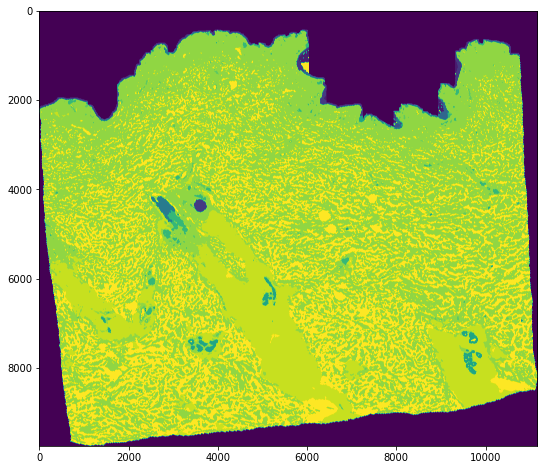

In [148]:
figure_size = plt.gcf().get_size_inches()
factor = 2
plt.gcf().set_size_inches(factor * figure_size)
plt.imshow(derm)

In [135]:
derm4 = (derm ==4)
derm4_mask = derm4 * derm

# all of these are misclassified epidermis as hair follicle
# replace small objects with adjacent pixels
# replace any not round object with adjacent pixels

#write a logic that determines if an object is follicle
#logic includes (size, shape)
# first determine the minimum size of hair follicle
#shape can be measured using scikit.measure.regionprops or cv2 contour properties
# https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
# https://docs.opencv.org/4.x/d1/d32/tutorial_py_contour_properties.html
#write function that replace a selected object with adjacent pixels

In [158]:
derm4_filled = ndimage.binary_fill_holes(derm4).astype(int)

In [159]:
derm4_holes = derm4_filled ^ derm4

In [166]:
#5 should not have anything inside it, 5 should only touch 12 , 10
#should 5 be really small ?
derm5 = (derm == 5)
derm5 = ndimage.binary_fill_holes(derm5).astype(int) #fill 5


In [185]:
#if 5 is npt touching 12 and 10, is 5 wrong?
dilate5 = ndimage.binary_dilation(derm5).astype(derm5.dtype)
ring5 = dilate5 - derm5


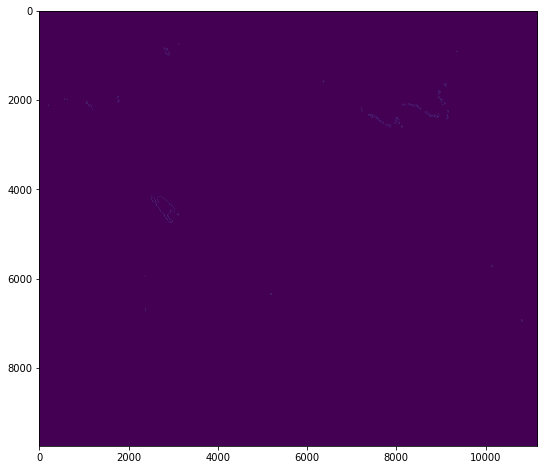

In [207]:
figure_size = plt.gcf().get_size_inches()
factor = 2
plt.gcf().set_size_inches(factor * figure_size)
plt.imshow(ring5)

In [ ]:
# 5. iterate each class to replace any potentially wrong pixel to correct class